In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1.  Cargar los datos y Graficar.

In [3]:
csv = pd.read_csv('/content/drive/MyDrive/Datos_Analisis_Proyect1/Puebla_pos.csv')

Df = pd.DataFrame(csv)

Df = Df.drop(["Unnamed: 0"], axis=1)
Df.rename(columns={"FECHA_SINTOMAS":'Fechas', "positivo":"Casos positivos"}, inplace=True) 
Df

,Fechas,Casos positivos
0,2020-03-02,1
1,2020-03-05,2
2,2020-03-08,3
3,2020-03-09,4
4,2020-03-10,3
...,...,...
673,2022-01-09,493
674,2022-01-10,556
675,2022-01-11,287
676,2022-01-12,149


In [4]:
Df['Fechas'] = pd.to_datetime(Df['Fechas'])

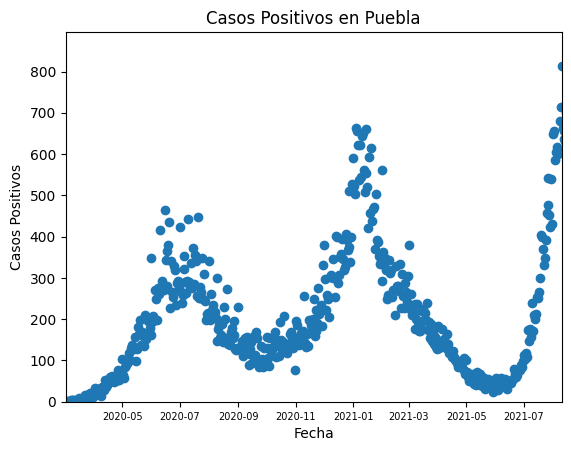

In [5]:
# Encuentra el índice del valor máximo y obtén la fecha correspondiente
max_index = Df['Casos positivos'].argmax()
max_date = Df.loc[max_index, 'Fechas']

plt.scatter(Df['Fechas'], Df['Casos positivos'])
plt.xlabel('Fecha')
plt.ylabel('Casos Positivos')
plt.title('Casos Positivos en Puebla')
plt.xlim(Df['Fechas'].min(), max_date) # ajusta el eje x hasta la fecha del valor máximo
plt.ylim(0, Df['Casos positivos'].max() * 1.1) # ajusta el eje y (casos positivos)
plt.xticks(fontsize=7)
plt.show()

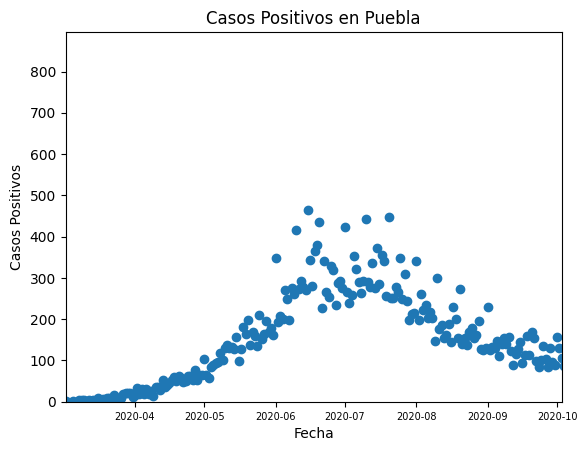

In [6]:
plt.scatter(Df['Fechas'], Df['Casos positivos'])
plt.xlabel('Fecha')
plt.ylabel('Casos Positivos')
plt.title('Casos Positivos en Puebla')
plt.xlim(Df['Fechas'].min(), Df.loc[210, 'Fechas']) # ajusta el eje x hasta la fecha del valor máximo
plt.ylim(0, Df['Casos positivos'].max() * 1.1) # ajusta el eje y (casos positivos)
plt.xticks(fontsize=7)
plt.show()

2.- Ajustar la primera ola con minimos cuadrados

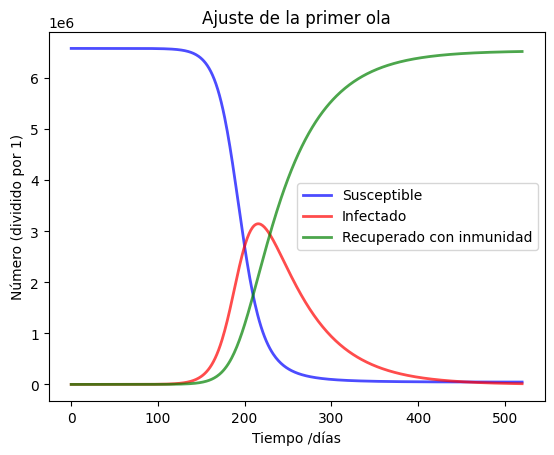

In [7]:
# crear una columna con los casos acumulados
Df['Casos acumulados'] = Df['Casos positivos'].cumsum()

# definir el modelo SIR
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def plot(S, I, R, t, divide_by=1):
    # Dibujamos los datos de S(t), I(t) y R(t)
    fig, ax = plt.subplots()
    ax.plot(t, S / divide_by, 'b', alpha=0.7, lw=2, label='Susceptible')
    ax.plot(t, I / divide_by, 'r', alpha=0.7, lw=2, label='Infectado')
    ax.plot(t, R / divide_by, 'g', alpha=0.7, lw=2, label='Recuperado con inmunidad')
    ax.set_xlabel('Tiempo /días')
    ax.set_ylabel(f'Número (dividido por {divide_by:,})')
    ax.set_title("Ajuste de la primer ola")
    legend = ax.legend()

N = 6_583_000 # Población suceptible de Puebla
 
# Número inicial de infectados y recuperados, I0 and R0.
I0 = Df.iloc[0,2]
R0 = 0
 
# El resto, casi todo N, es susceptible de infectarse
S0 = N - I0 - R0
 
# Tasas de contagio y recuperación.
beta = 0.1 # contagio
gamma = 0.02 # recuperación
 
# Pasos temporales (en días)
t = np.arange(max_index)
 
# condiciones iniciales
y0 = S0, I0, R0

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T
 
plot(S, I, R, t) # Datos sin normalizar

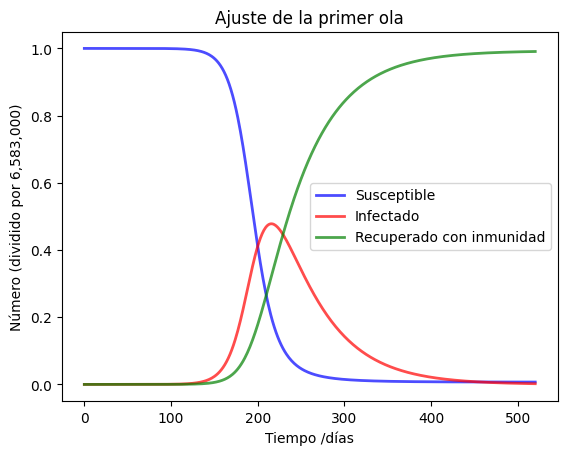

In [8]:
plot(S, I, R, t, divide_by=N) # Datos normalizados

Comparación con la primer ola estimada visualmente.

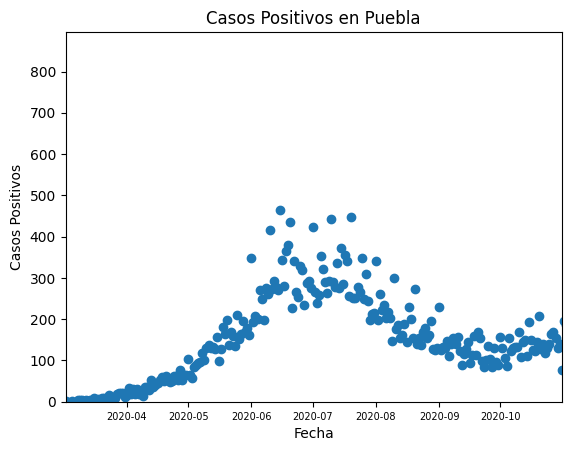

In [9]:
plt.scatter(Df['Fechas'], Df['Casos positivos'])
plt.xlabel('Fecha')
plt.ylabel('Casos Positivos')
plt.title('Casos Positivos en Puebla')
plt.xlim(Df['Fechas'].min(), Df.loc[238, 'Fechas']) # ajusta el eje x hasta la fecha del valor máximo
plt.ylim(0, Df['Casos positivos'].max() * 1.1) # ajusta el eje y (casos positivos)
plt.xticks(fontsize=7)
plt.show()

3.  Ajustar la segunda ola con una cadena de Monte Carlo y dar intervalosde confianza para los parámetros.

Segunda ola estimada visualmente.

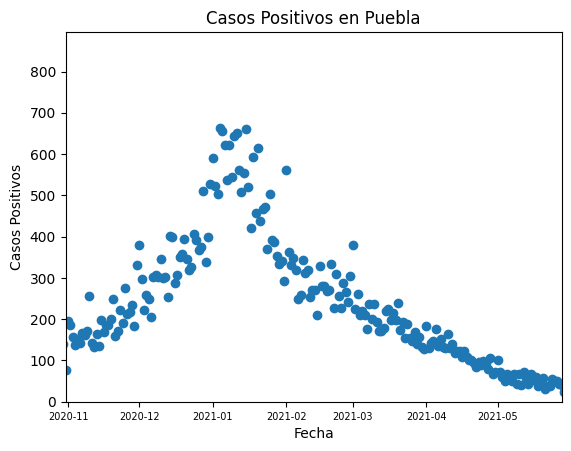

In [10]:
plt.scatter(Df['Fechas'], Df['Casos positivos'])
plt.xlabel('Fecha')
plt.ylabel('Casos Positivos')
plt.title('Casos Positivos en Puebla')
plt.xlim(Df.loc[238, 'Fechas'], Df.loc[447, 'Fechas']) # ajusta el eje x hasta la fecha del valor máximo
plt.ylim(0, Df['Casos positivos'].max() * 1.1) # ajusta el eje y (casos positivos)
plt.xticks(fontsize=7)
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

# Función que define el modelo SIR
def SIR_model(t, N, beta, gamma, I0):
    S0 = N - I0
    S = np.zeros(len(t))
    I = np.zeros(len(t))
    R = np.zeros(len(t))
    S[0] = S0
    I[0] = I0
    R[0] = 0
    for i in range(1, len(t)):
        S[i] = S[i-1] - (beta * S[i-1] * I[i-1] / N)
        I[i] = I[i-1] + (beta * S[i-1] * I[i-1] / N) - gamma * I[i-1]
        R[i] = R[i-1] + gamma * I[i-1]
    return I

# Función para realizar el ajuste mediante el método de Monte Carlo
def fit_MC(xdata, ydata, p0, bounds, Nsim):
    params_MC = np.zeros((len(p0), Nsim))
    for i in range(Nsim):
        ydata_MC = ydata + np.random.normal(0, 1, len(ydata))
        popt, pcov = curve_fit(SIR_model, xdata, ydata_MC, p0=p0, bounds=bounds)
        params_MC[:,i] = popt
    return params_MC

# Datos de ejemplo
xdata = np.arange(1, 11)
ydata = np.array([2, 5, 10, 25, 80, 150, 200, 250, 300, 350])

# Parámetros iniciales y límites para el ajuste
p0 = (6_000_000, 0.2, 0.1, 2)
bounds = ((1_000_000, 0.1, 0.01, 1), (10_000_000, 0.5, 0.5, 10))

# Realizar el ajuste mediante el método de Monte Carlo
Nsim = 1000
params_MC = fit_MC(xdata, ydata, p0, bounds, Nsim)

# Obtener los intervalos de confianza del 95%
alpha = 0.95
conf_int = np.zeros((len(p0), 2))
for i in range(len(p0)):
    mean = np.mean(params_MC[i,:])
    std = np.std(params_MC[i,:])
    conf_int[i,:] = norm.interval(alpha, loc=mean, scale=std/np.sqrt(Nsim))

# Imprimir los resultados
print("Parámetros ajustados mediante Monte Carlo:")
for i, name in enumerate(['N', 'beta', 'gamma', 'I0']):
    print(f"{name}: {np.mean(params_MC[i,:]):.2f} +/- {np.std(params_MC[i,:]):.2f} ({conf_int[i,0]:.2f}, {conf_int[i,1]:.2f})")

Parámetros ajustados mediante Monte Carlo:
N: 10000000.00 +/- 0.00 (10000000.00, 10000000.00)
beta: 0.50 +/- 0.00 (0.50, 0.50)
gamma: 0.01 +/- 0.00 (0.01, 0.01)
I0: 10.00 +/- 0.00 (10.00, 10.00)
